In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera
import arch
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score, mean_absolute_error
from arch import arch_model
import data_reader as dr
import metrics as mt

In [2]:
data, target = dr.read_data(window=22)
data.info()
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2433 entries, 0 to 2432
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2433 non-null   object 
 1   Daily_trading_range  2433 non-null   float64
 2   Log_Volume_change    2433 non-null   float64
 3   Daily_return         2433 non-null   float64
 4   Daily_log_return     2433 non-null   float64
 5   Index                2433 non-null   float64
dtypes: float64(5), object(1)
memory usage: 114.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2411 entries, 0 to 2410
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  2411 non-null   float64
dtypes: float64(1)
memory usage: 37.7 KB


In [3]:
target.tail()

,Target
2406,0.181086
2407,0.180976
2408,0.180241
2409,0.177022
2410,0.177207


In [4]:
def evaluate(predict, target, title):
    # rev_pred = scaler.inverse_transform(predict)
    # rev_true = scaler.inverse_transform(target)
    print('--------'+title+'----------')
    testScore = mean_squared_error(predict, target)
    print("test Score: {score} MSE".format(score=testScore))
    root_testScore = mean_squared_error(y_pred=predict, y_true=target, squared=False)
    print("test Score: {score} RMSE".format(score=root_testScore))
    mape = mean_absolute_percentage_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAPE".format(score=mape))
    mae = mean_absolute_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAE".format(score=mae))
    # r2_test = r2_score(y_true=target, y_pred=predict)
    # print("test Score: {score} R2 score".format(score=r2_test))


In [5]:
split_index = int(len(data)*0.8)
print('Split index: ', split_index)
print('Observations: ', len(data))

Split index:  1946
Observations:  2433


In [6]:
def create_garch(data, target, p=1, q=1):
    logreturns = np.array(data[['Daily_log_return']])
    window = 22
    n_ahead = 1
    garch_pred = []
    for i in range(split_index-1, len(logreturns)-n_ahead):
        train = logreturns[:i]*100
        gm = arch_model(train, p=p, q=q, dist='studentst')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        vol = np.sqrt(pred.variance.values[-1,:].mean())*0.01*np.sqrt(252)
        garch_pred.append(vol)

    title = 'GARCH({},{}) prediction'.format(p, q)
    split_target = np.array(target.iloc[split_index-22:])
    plot(garch_pred, split_target, title, save=False)

    print('---------GARCH({},{}) estimation-----------'.format(p,q))
    mt.testScore(pred=garch_pred, target=split_target)

In [7]:
def create_gjr(data, target, p=1, q=1, o=1):
    logreturns = np.array(data[['Daily_log_return']].dropna())
    window = 22
    gjr_pred = []
    for i in range(split_index-1, len(logreturns)-1):
        train = logreturns[:i] * 100
        gm = arch_model(train, p=p, q=q, o=o, dist='studentst')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=1)
        gjr_pred.append(np.sqrt(pred.variance.values[-1, :].mean()) *0.01* np.sqrt(252))

    title = 'GJR-GARCH({},{}) prediction'.format(p,q)
    split_target = np.array(target.iloc[split_index-22:])
    plot(gjr_pred, split_target, title, save=False)

    print('---------GJR-GARCH({},{}) estimation-----------'.format(p,q))
    mt.testScore(pred=gjr_pred, target=split_target)


In [8]:
def plot(predict, target, title, save=False):
    plt.plot(predict, label='predict')
    plt.plot(target, label='target')
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig('images/'+title)
    plt.show()

In [9]:
logreturn = data[['Daily_log_return']]
logreturn

,Daily_log_return
0,0.007249
1,-0.001243
2,-0.002375
3,0.004126
4,-0.002587
...,...
2428,0.019042
2429,0.005812
2430,-0.006215
2431,0.009324


In [10]:
kurtosis = logreturn.kurtosis()
skewness = logreturn.skew()
print('Kurtosis: ', kurtosis)
print('Skewness: ', skewness)

Kurtosis:  Daily_log_return    8.145594
dtype: float64
Skewness:  Daily_log_return   -0.365287
dtype: float64


array([[<AxesSubplot:title={'center':'Daily_log_return'}>]], dtype=object)

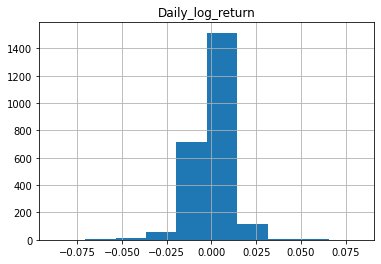

In [11]:
logreturn.describe()
logreturn.hist()

In [12]:
jarque_bera(logreturn)

Jarque_beraResult(statistic=6748.679156990025, pvalue=0.0)

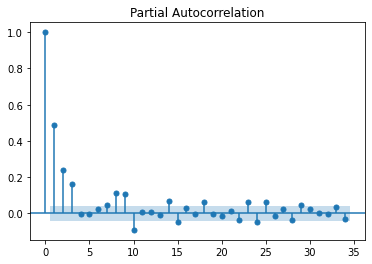

In [13]:
plot_pacf(logreturn**2)
# plt.savefig('images/pacf.png')
plt.show()

In [14]:
for i in range(3):
    for j in range(3):
        gm_model = arch_model(logreturn*100, p=i+1,q=j+1, dist='skewt')
        gjr_model = arch_model(logreturn*100, p=i+1, q=j+1, o=i+1,dist='skewt')
        gm_fit = gm_model.fit(disp='off')
        gjr_fit = gjr_model.fit(disp='off')

        print('GARCH({},{}) AIC, BIC: {:.3f} and {:.3f}'.format(i+1,j+1,gm_fit.aic, gm_fit.bic))
        print('GJR-GARCH({},{}) AIC, BIC: {:.3f} and {:.3f}'.format(i+1,j+1,gjr_fit.aic, gjr_fit.bic))

GARCH(1,1) AIC, BIC: 6198.668 and 6233.449
GJR-GARCH(1,1) AIC, BIC: 6148.162 and 6188.740
GARCH(1,2) AIC, BIC: 6200.668 and 6241.246
GJR-GARCH(1,2) AIC, BIC: 6149.690 and 6196.065
GARCH(1,3) AIC, BIC: 6202.668 and 6249.043
GJR-GARCH(1,3) AIC, BIC: 6150.725 and 6202.897
GARCH(2,1) AIC, BIC: 6197.989 and 6238.567
GJR-GARCH(2,1) AIC, BIC: 6151.827 and 6203.999
GARCH(2,2) AIC, BIC: 6198.032 and 6244.407
GJR-GARCH(2,2) AIC, BIC: 6153.603 and 6211.572
GARCH(2,3) AIC, BIC: 6193.931 and 6246.103
GJR-GARCH(2,3) AIC, BIC: 6154.465 and 6218.230
GARCH(3,1) AIC, BIC: 6199.989 and 6246.364
GJR-GARCH(3,1) AIC, BIC: 6155.640 and 6219.405
GARCH(3,2) AIC, BIC: 6200.032 and 6252.204
GJR-GARCH(3,2) AIC, BIC: 6157.364 and 6226.926
GARCH(3,3) AIC, BIC: 6195.929 and 6253.898
GJR-GARCH(3,3) AIC, BIC: 6157.080 and 6232.440


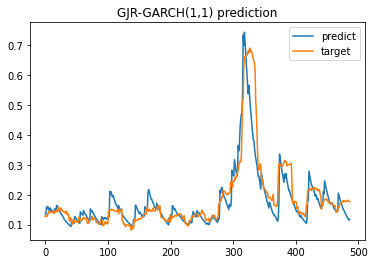

---------GJR-GARCH(1,1) estimation-----------
MSE Score: 0.002534871347805049
RMSE Score: 0.05034750587472083
MAPE Score: 0.14110764088517128
MAE Score: 0.02945464191844856
---------GARCH(1,1) estimation-----------
MSE Score: 0.0011080769791259497
RMSE Score: 0.03328779024095697
MAPE Score: 0.10337297916341066
MAE Score: 0.02020399536195273


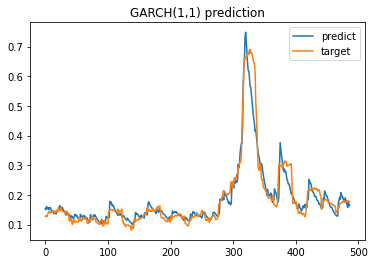

In [15]:
create_gjr(data, target, p=1,q=1)
create_garch(data, target, p=1,q=1)

In [16]:
gm = arch_model(logreturn*100, p=1,q=1, dist='skewt')
gm_fit = gm.fit()
gm_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 133645.14628477755
Iteration:      2,   Func. Count:     19,   Neg. LLF: 225953.53725427104
Iteration:      3,   Func. Count:     28,   Neg. LLF: 67850.19337247062
Iteration:      4,   Func. Count:     37,   Neg. LLF: 55320.980051010396
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5867.557386707074
Iteration:      6,   Func. Count:     54,   Neg. LLF: 5113.344964884956
Iteration:      7,   Func. Count:     62,   Neg. LLF: 3183.200258020753
Iteration:      8,   Func. Count:     70,   Neg. LLF: 3101.565285352244
Iteration:      9,   Func. Count:     78,   Neg. LLF: 8924.96061596832
Iteration:     10,   Func. Count:     86,   Neg. LLF: 3094.950911483029
Iteration:     11,   Func. Count:     94,   Neg. LLF: 3093.4241722182232
Iteration:     12,   Func. Count:    102,   Neg. LLF: 3093.336014767304
Iteration:     13,   Func. Count:    109,   Neg. LLF: 3093.3340272137925
Iteration:     14,   Func. Count:    116,   Neg. LLF: 3093.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                  Daily_log_return   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                                 GARCH   Log-Likelihood:               -3093.33
Distribution:      Standardized Skew Student's t   AIC:                           6198.67
Method:                       Maximum Likelihood   BIC:                           6233.45
                                                   No. Observations:                 2433
Date:                           Tue, Apr 20 2021   Df Residuals:                     2427
Time:                                   01:48:52   Df Model:                            6
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0177  1.651e-02      1.071      0.284 [-1.468e-02,5.002e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0190  7.435e-03      2.550  1.077e-02 [4.388e-03,3.353e-02]
alpha[1]       0.0820  1.751e-02      4.682  2.836e-06   [4.768e-02,  0.116]
beta[1]        0.8992  2.273e-02     39.560      0.000     [  0.855,  0.944]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
nu             6.2469      0.744      8.391  4.808e-17    [  4.788,  7.706]
lambda        -0.1245  2.531e-02     -4.917  8.809e-07 [ -0.174,-7.484e-02]
===========================================================================

Covariance estimator: robust
"""

In [16]:
gm_fit.conditional_volatility

0       0.831888
1       0.825992
2       0.796310
3       0.771037
4       0.752549
          ...   
2428    1.003681
2429    1.103033
2430    1.067265
2431    1.037651
2432    1.027509
Name: cond_vol, Length: 2433, dtype: float64

## Results
| Models        | AIC        | BIC       |
| :------------ |:----------:| :---------:|
| **GARCH(1,1)**    | **6253.84**    | **6276.98**   |
| GARCH(1,2)    | 6255.84    | 6284.77   |
| GARCH(1,3)    | 6257.84    | 6292.55   |
| GARCH(2,1)    | 6254.79    | 6283.72   |
| GARCH(2,2)    | 6256.15    | 6290.87   |
| GARCH(2,3)    | 6257.22    | 6297.72   |
| GARCH(3,1)    | 6256.79    | 6291.51   |
| GARCH(3,2)    | 6258.15    | 6298.65   |
| GARCH(3,3)    | 6258.95    | 6305.23   |
| GJR-GARCH(1,1)    | 6194.82    | 6223.75   |
| **GJR-GARCH(1,2)**    | **6192.65**    | **6227.36**   |
| GJR-GARCH(1,3)    | 6193.64    | 6234.14   |
| GJR-GARCH(2,1)    | 6196.32    | 6236.82   |
| GJR-GARCH(2,2)    | 6195.33    | 6241.61   |
| GJR-GARCH(2,3)    | 6196.69    | 6248.77   |
| GJR-GARCH(3,1)    | 6199.01    | 6251.08   |
| GJR-GARCH(3,2)    | 6199.23    | 6257.09   |
| GJR-GARCH(3,3)    | 6200.69    | 6264.34   |